In [71]:
PATH = './experiments'

In [72]:
import pandas as pd

In [100]:
import re
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import pickle
import itertools

from pathlib import Path as PPath
from multiprocessing import Pool

from genetic.data_definitions import CartesianPoint, Mapa, Version
from genetic.visualization import plot_map, vis_mapa

from genetic.genetic import Genetic, Subject

import ast

from math import sqrt

In [74]:
    wp_ori = CartesianPoint(0, 0)
    wp_des = CartesianPoint(0, -10)

### Open maps

#### read sgl

In [75]:
def sgl_read_areas(lines):
    """From the map file definition reads each area"""

    lines = iter(lines)
    next(lines)  # <number of polygons>
    next(lines)  # 20

    areas = []

    for line in lines:
        Xs = [float(n) for n in re.sub(r"\n", "", next(lines)).split(",")]
        Ys = [float(n) for n in re.sub(r"\n", "", next(lines)).split(",")]

        areas.append([CartesianPoint(x, y) for x, y in zip(Xs, Ys)])

    return areas


def read_sgl(path, **kwargs):
    with open(path, "r") as f:
        lines = f.readlines()
        map = Mapa(
            wp_ori, wp_des, sgl_read_areas(lines), **kwargs
        )  # inflation_rate=1, mode='scalar'
    return map



#### open

In [76]:
mapa = read_sgl('./maps/NonRegular/31.sgl')

### Open AG Results

In [120]:
with open(PATH+'/mode_F_map_31_exec_1_history.csv') as f:
    df = pd.read_csv(f)

Get best individual of all times

In [121]:
df.min()

id                                                               0
generation                                                       0
parents                                                    [0, 21]
fitness                                                    714.747
fitness_trace    [10.008417313952817, 0, 0.6736685209220344, 1....
birth_time                                              0.00066781
route            [[0, 0], [-0.0019805671713002404, 0.0], [0.083...
dtype: object

In [125]:
df.loc[df['fitness'] <= 715]

,id,generation,parents,fitness,fitness_trace,birth_time,route
231,231,38,"[209, 228]",714.746851,"[6.808877511734868, 0, 5.006361174947548, 1.29...",18.090202,"[[0, 0], [-0.4748202924680287, 0.0], [-0.26482..."
232,232,39,"[230, 231]",714.746851,"[6.808877511734868, 0, 5.006361174947548, 1.29...",18.185438,"[[0, 0], [-0.4748202924680287, 0.0], [-0.26482..."
233,233,40,"[228, 232]",714.746851,"[6.808877511734868, 0, 5.006361174947548, 1.29...",18.375353,"[[0, 0], [-0.4748202924680287, 0.0], [-0.26482..."
240,240,43,"[236, 233]",714.746851,"[6.808877511734868, 0, 5.006361174947548, 0.79...",18.845456,"[[0, 0], [-0.4748202924680287, 0.0], [-0.26482..."
242,242,43,"[241, 240]",714.746851,"[6.808877511734868, 0, 5.006361174947548, 0.79...",18.924532,"[[0, 0], [-0.4748202924680287, 0.0], [-0.26482..."
244,244,44,"[229, 242]",714.746851,"[6.808877511734868, 0, 5.006361174947548, 0.79...",19.144453,"[[0, 0], [-0.4748202924680287, 0.0], [-0.26482..."
245,245,44,"[243, 242]",714.746851,"[6.808877511734868, 0, 5.006361174947548, 0.79...",19.165524,"[[0, 0], [-0.4748202924680287, 0.0], [-0.26482..."
246,246,45,"[225, 242]",714.746851,"[6.808877511734868, 0, 5.006361174947548, 0.79...",19.269192,"[[0, 0], [-0.4748202924680287, 0.0], [-0.26482..."


In [81]:
bestindex = 81

In [90]:
for stat in df.loc[bestindex]:
    print(stat)

81
15
[72, 80]
740.2478050069768
[704.7250945293949, 0, 0.0, 0.0, 30, 5.522710477581892]
8.068397045135496
[[0, 0], [-0.8630837931823053, 0.0], [1.0252323941809784, -0.2691729447398364], [0.9783946928071209, -3.0209965101718628]]


Get best's route

In [83]:
route = df.loc[bestindex]['route']
route = ast.literal_eval(route)

### vis_mapa

In [84]:
route

[[0, 0],
 [-0.8630837931823053, 0.0],
 [1.0252323941809784, -0.2691729447398364],
 [0.9783946928071209, -3.0209965101718628]]

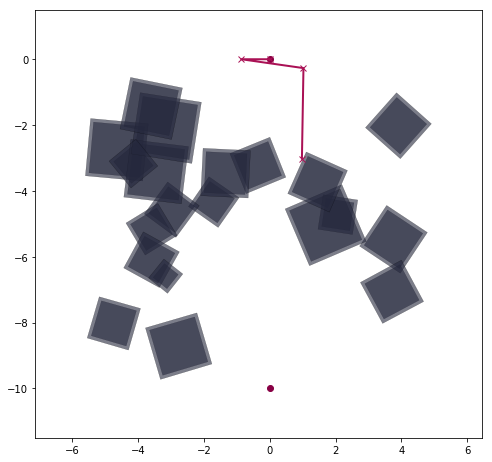

In [85]:
vis_mapa(mapa, route)

# AG

In [56]:
import pickle

In [117]:
with open(PATH+'/mode_F_map_31_exec_1_ag.p', 'rb') as f:
    ag = pickle.loads(f.read())

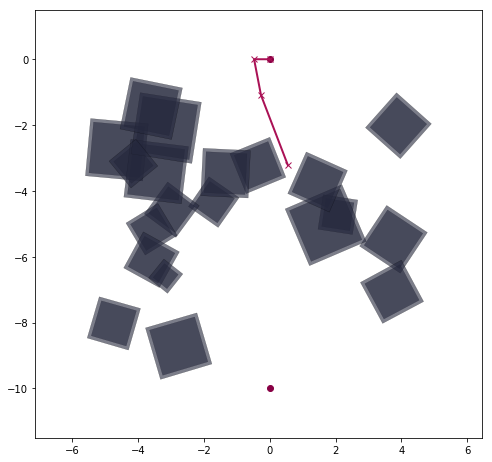

In [118]:
vis_mapa(mapa, ag.best.get_route())

In [119]:
#fit_d fit_obs fit_con fit_cur fit_t fit_dist
ag.best.fitness_trace

[6.808877511734868,
 0,
 5.006361174947548,
 1.2938938435920524,
 3,
 3.8591002792223756]

In [123]:
ag.best.fitness

714.7468514527092

### Fitness debug

In [105]:
__fitness_destination(ag.best, mapa) * 700 # * C_dest

4933.075661705765

In [103]:
min_precision = 1
def __fitness_destination(subject, mapa):
        # Prioriza rotas que acertem o destino

        A = subject.dna_decoded[-1]  # Último waypoint da rota
        B = mapa.destination  # Waypoint de destino

        # Distância euclidiana entre o último ponto da rota e o ponto de destino
        d = sqrt((B.x - A.x) ** 2 + (B.y - A.y) ** 2)

        # Determina uma precisão mínima aceita
        if d < min_precision:  # min_precision default = 1.0
            return 0
        return d